# DS200A Computer Vision Assignment
---

## Preliminary EDA (NB2a) - Table of contents
In this section, we would like to do some explatoratory research to get a better feel for the data. We will use this to understand which features could be useful.

> ### Part 1. [Retrieve cleaned images from NB1](#fetch)
> ### Part 2. [Define helper functions for EDA ](#helper)
> ### Part 3. [EDA visualizations](#graphs)

---

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_doh, peak_local_max
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage import filters 

import seaborn as sns 
import scipy
import scipy.cluster
import binascii
import os
import time 

# External libraries not part of Jupyter dependencies 
!pip install opencv-python     
import cv2
!pip install webcolors
import webcolors 
!pip install Pillow
from PIL import Image

---

<a id="fetch"></a>

### Part 1. Retrieve cleaned images from NB1 

Now that we've cached pickle files from NB1, we can retrieve them without having to rerun NB1.

In [3]:
def get_cleaned_images(isTest=False):
    """
    Returns the cleaned training or validation set images.
    
    Keyword arguments: 
    isTest (bool) -- test set if True, train set if False. 
    
    Returns: 
        pd.DataFrame with cleaned images. 
    """
    cache_name = 'cleaned_test.pkl' if isTest else 'cleaned_train.pkl'
        
    if Path(cache_name).is_file():
        image_df = pd.read_pickle(cache_name)
        print(f"Success: {len(image_df)} images loaded into {'test' if isTest else 'train'} dataframe")
        return image_df
    else:
        print("Error: data file does not exist. Please create it in part 1!")

training_data = get_cleaned_images()
validation_data = get_cleaned_images(isTest=True)

Success: 1501 images loaded into train dataframe
Success: 716 images loaded into test dataframe


<a id="helper"></a>

### Part 2. Define helper functions for EDA 
Preliminary EDA is useful for understanding the data and identifying key features. In this section, we find the dominant color clusters for each image. Color distribution is found by K-Means Clustering pixels into K groups of similar colors. Obviously, much more EDA could and should be done!! 

In [4]:
def closest_color(requested_color):
    """
    Finds the RGB color that is closed to the requested color.
    
    Keyword arguments: 
    requested_color (3-tuple) -- color to match. 
    
    Returns: 
        Closest RGB colour (3-tuple)
    """
    min_colors = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return min_colors[min(min_colors.keys())]

def get_color_name(requested_color):
    """
    Convert a color (3-tuple of ints) into its color name if it exists.
    
    Keyword arguments:
    requested_color -- color to match a name for.
    
    Returns: 
        name of color (string) 
    """
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_color)
    except ValueError:
        closest_name = closest_color(requested_color)
        actual_name = None
    return actual_name, closest_name

def get_color_name_from_image(image_path):
    """
    Finds the color distribution of the image,
    by K-Means clustering pixels into K groups of similar colors.
    
    Keyword arguments: 
    image_path -- path of the image 
    
    Returns: 
        color name of most domiant color (string) 
    """
    # Reformat image 
    NUM_CLUSTERS = 5
    im = Image.open(image_path)
    im = im.resize((150, 150)) # optional, reduce time
    ar = np.asarray(im)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS) # cluster

    vecs, dist = scipy.cluster.vq.vq(ar, codes) # assign codes
    counts, bins = scipy.histogram(vecs, len(codes)) # count occurrences

    index_max = scipy.argmax(counts) # find most frequent
    peak = codes[index_max]
    input = ''.join(chr(int(c)) for c in peak)
    color = binascii.hexlify ( bytes(input, 'utf-8') )
    hex_code = "#" + str(color).replace('b', '').replace("'", "")
    _, color_name = get_color_name(peak)
    return color_name 

# Example 
get_color_name_from_image('20_categories_training/airplanes/airplanes_0017.jpg')

def get_dominant_colors(image_folder='20_categories_training', cache_file='./colors.pkl'): 
    """
    Returns the most dominant colors for all images in specified folder.
    
    Keyword arguments:
    image_folder (string) -- path of image folder specified from root.
    cache_file (string) -- name of file used to cache results locally. 
    
    Returns: 
        pd.DataFrame containing the most dominant color names of all images 
    """
    if Path(cache_file).is_file(): 
        return pd.read_pickle(cache_file)
    
    popular_colors = []
    for parent_dir, sub_dir, files in os.walk(image_folder):
        for file in files:
            if ' ' not in file and not file.startswith('.'): 
                file_path = os.path.join(parent_dir, file)
                try: 
                    dominant_color = get_color_name_from_image(file_path)
                    popular_colors.append(dominant_color)
                except: 
                    continue # RGB (3-tuple) invalid
    colors_df = pd.DataFrame(np.array(popular_colors), columns=['color'])                
    
    if not Path(cache_file).is_file(): 
        colors_df.to_pickle(cache_file)
    return colors_df

def ensure_dir(file_path):
    """
    Check if directory exists or create it.
    This is used to to store cached color files.
    """
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

<a id="graphs"></a>
### Part 3. EDA Visualizations 
Next we will visualize our findings from Part 2. 

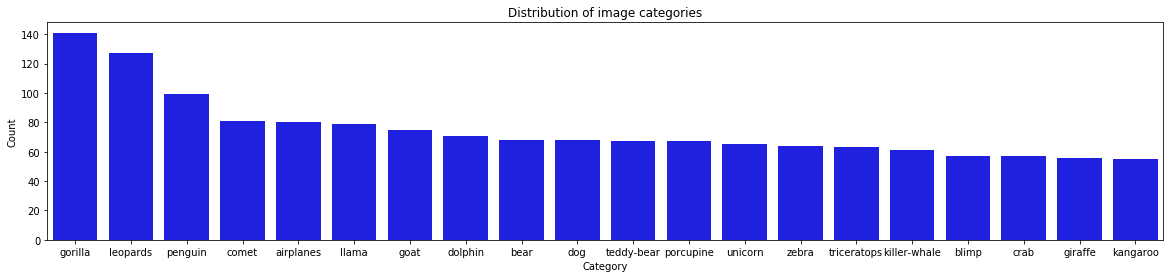

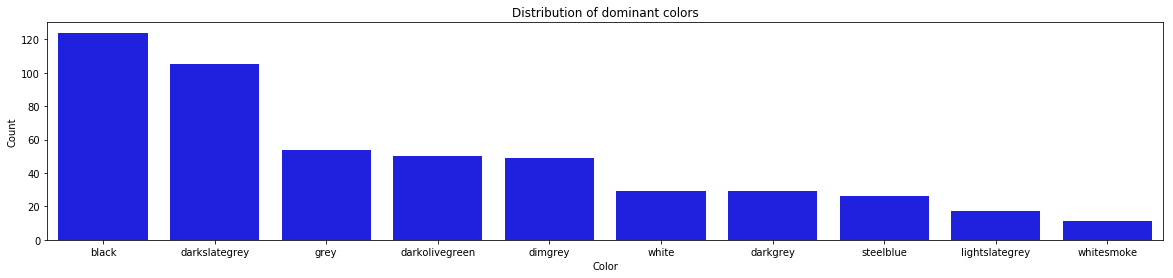

Finding dominant colors for category: airplanes
Finding dominant colors for category: bear
Finding dominant colors for category: blimp
Finding dominant colors for category: comet
Finding dominant colors for category: crab
Finding dominant colors for category: dog
Finding dominant colors for category: dolphin
Finding dominant colors for category: giraffe
Finding dominant colors for category: goat
Finding dominant colors for category: gorilla
Finding dominant colors for category: kangaroo
Finding dominant colors for category: killer-whale
Finding dominant colors for category: leopards
Finding dominant colors for category: llama
Finding dominant colors for category: penguin
Finding dominant colors for category: porcupine
Finding dominant colors for category: teddy-bear
Finding dominant colors for category: triceratops
Finding dominant colors for category: unicorn
Finding dominant colors for category: zebra


<Figure size 432x288 with 0 Axes>

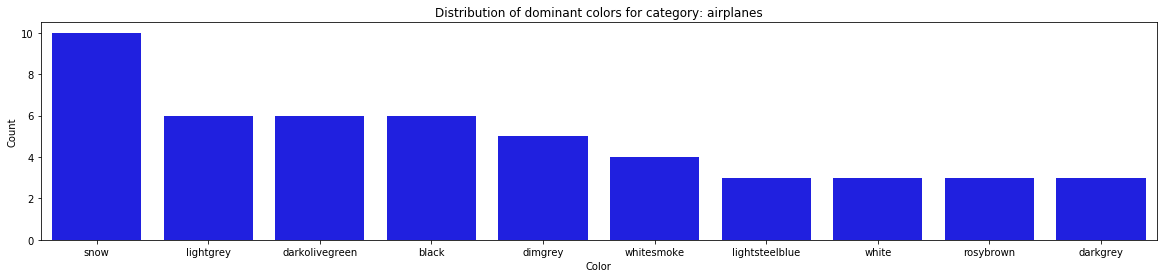

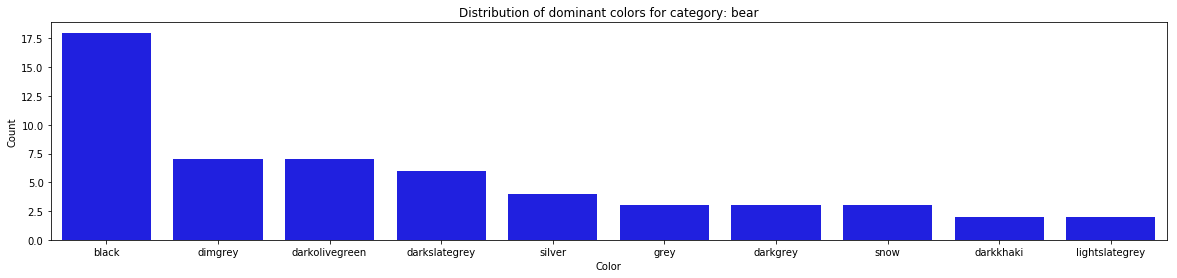

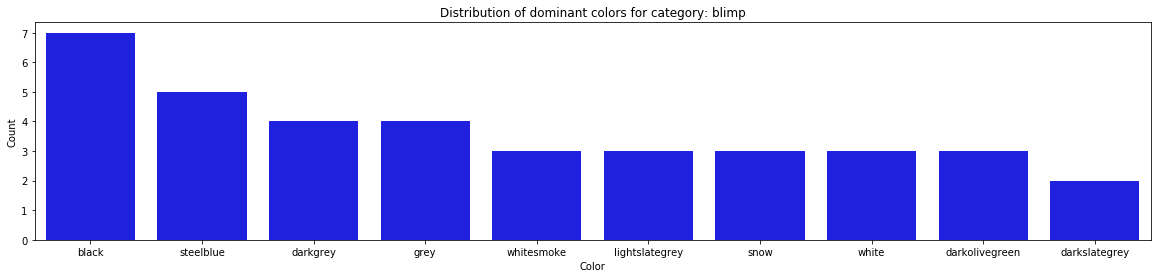

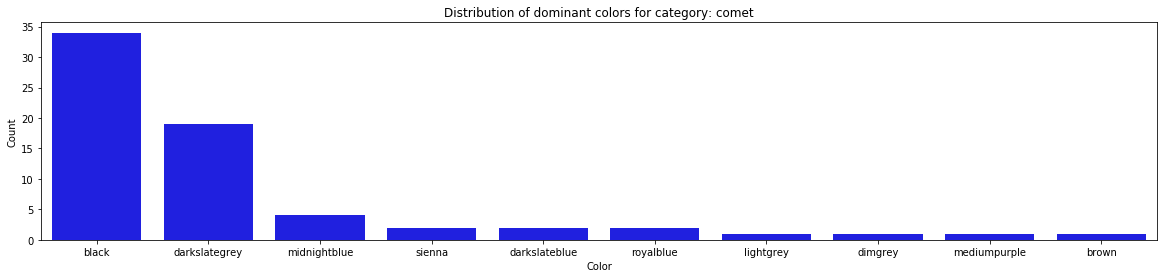

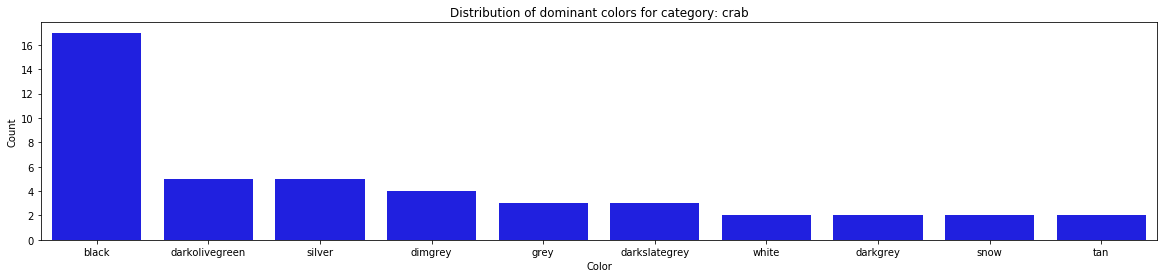

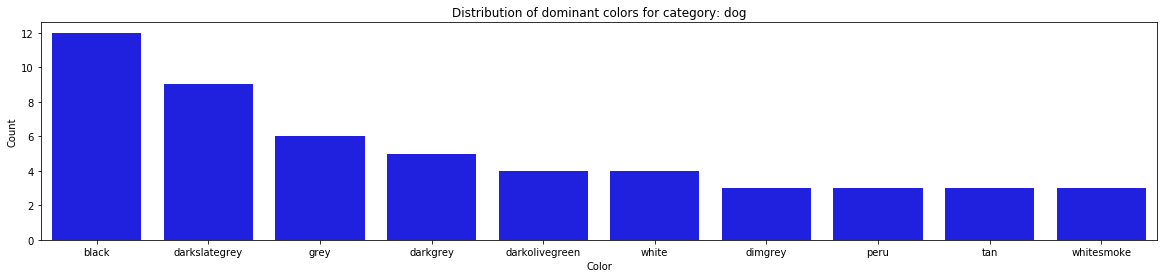

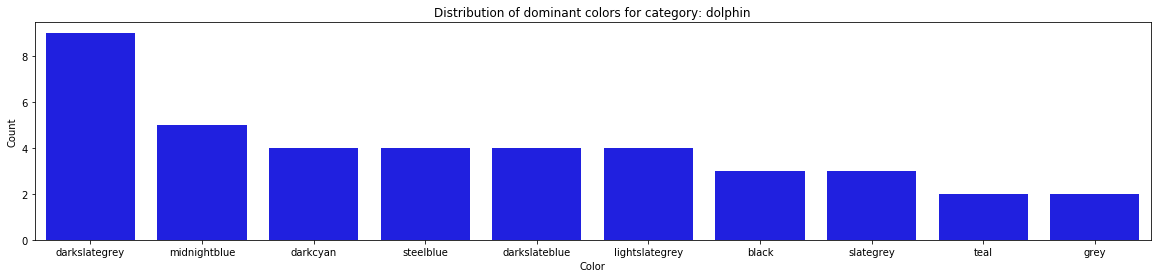

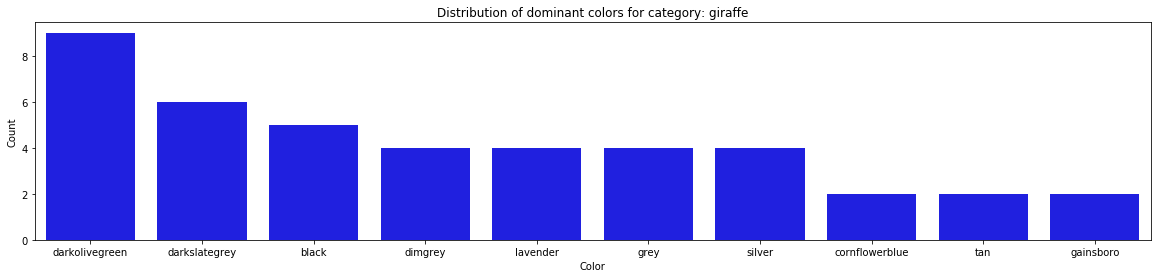

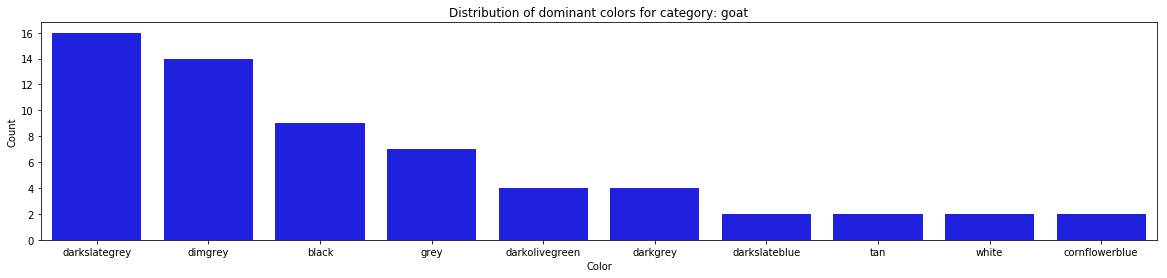

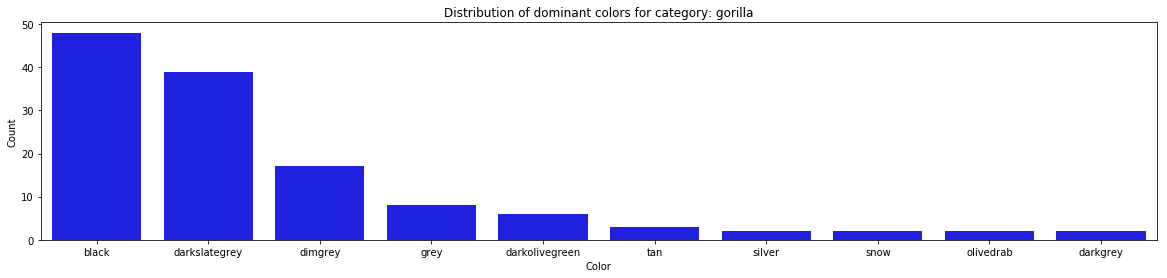

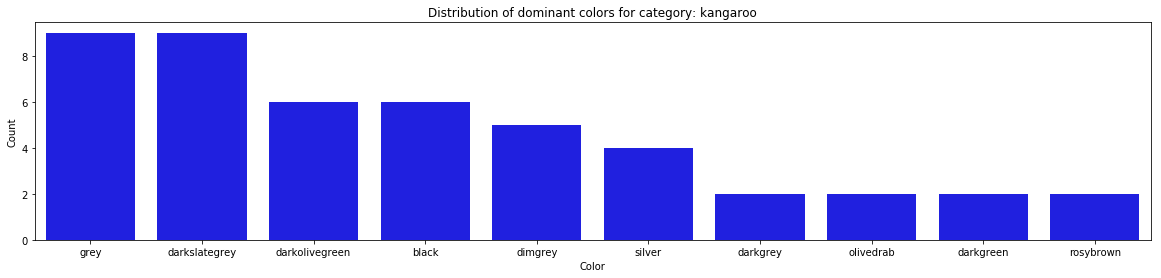

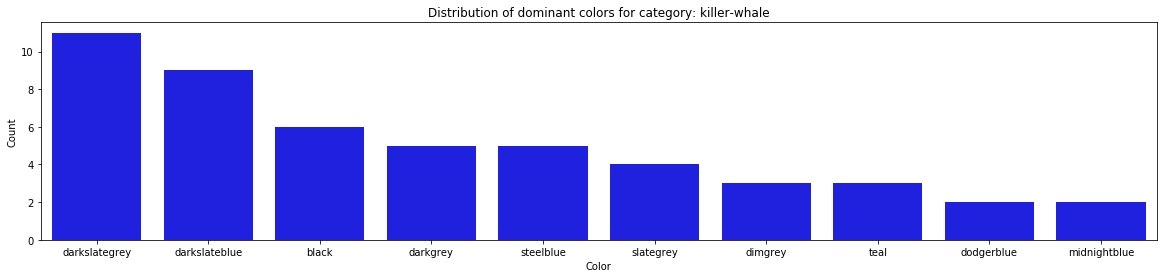

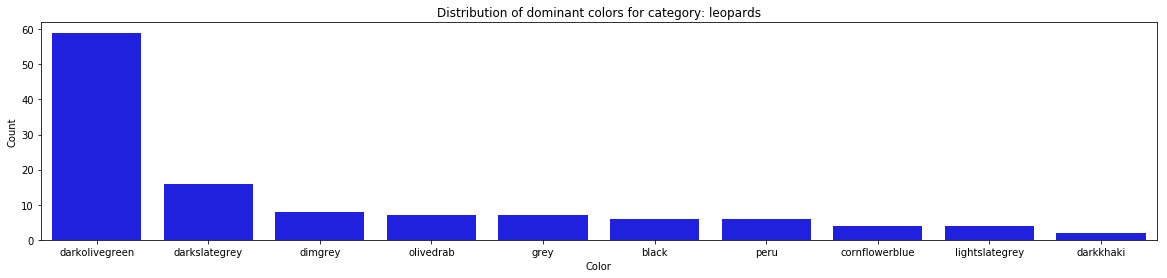

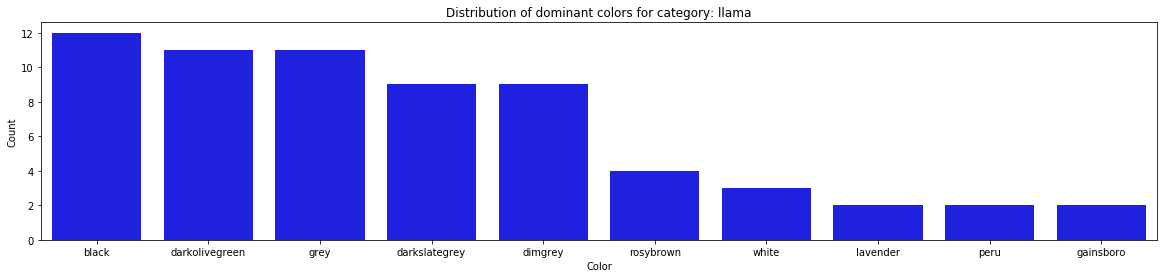

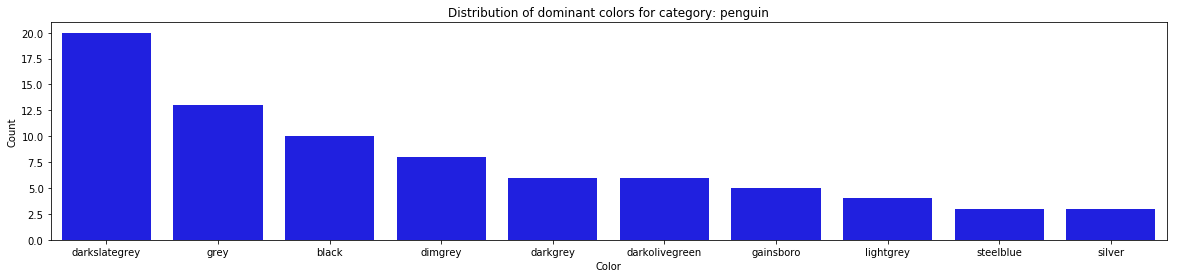

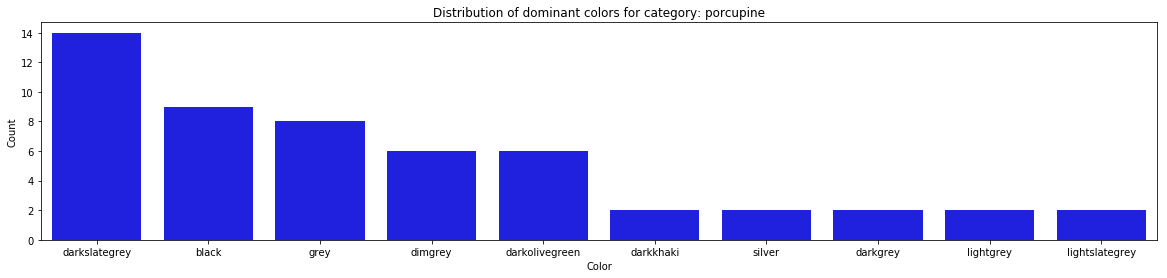

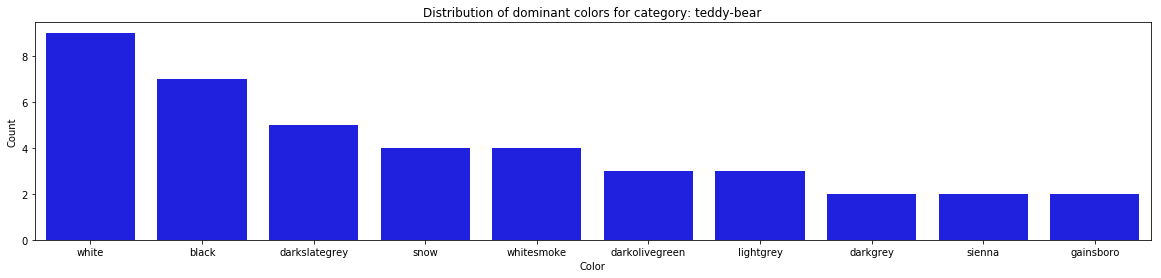

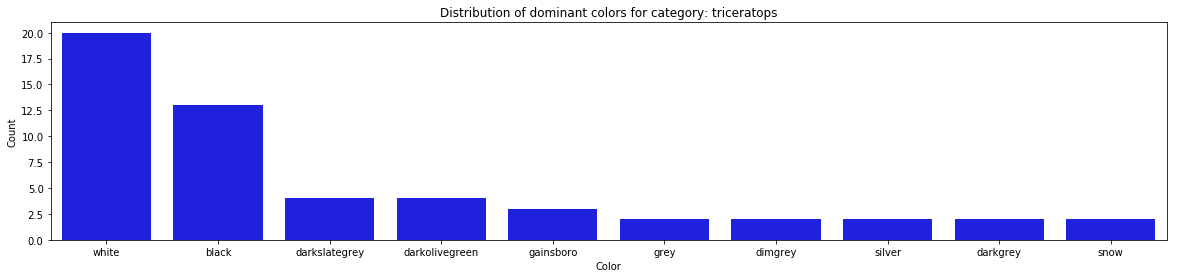

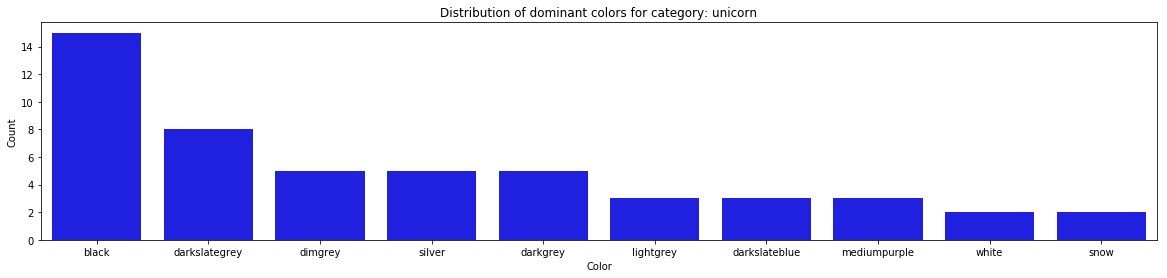

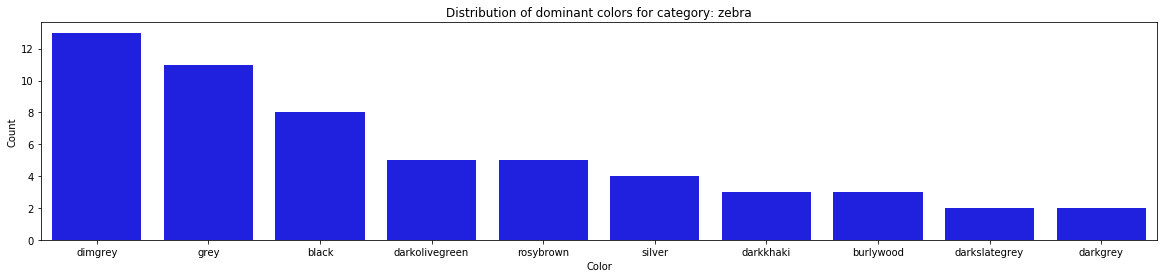

In [5]:
# Distribution of categories. How many images are of each category?
category_distribution = (training_data['category']
                         .value_counts()
                         .reset_index()
                        ) 
plt.figure(figsize=(20,4))
ax = sns.barplot(x='index', 
                 y='category', 
                 data=category_distribution, 
                color='blue')
ax.set_title('Distribution of image categories')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.show()

# Distribution of colors 
color_distribution = (get_dominant_colors('20_Validation')['color']
                      .value_counts()
                      .nlargest(10)
                      .reset_index()
                     )
plt.figure(figsize=(20,4))
color_plot = sns.barplot(x='index', 
                         y='color', 
                         data=color_distribution,
                         color='blue') 
color_plot.set_title('Distribution of dominant colors')
color_plot.set_xlabel('Color')
color_plot.set_ylabel('Count')
plt.show()

plt.subplots_adjust(bottom=0.1)

# Distribution of colors by category 
ensure_dir("./colors/")
colors_by_category = pd.DataFrame
for category_name in os.listdir('20_categories_training'): # find colors by category 
    if not category_name.startswith('.'): # hidden files 
        print(f"Finding dominant colors for category: {category_name}")
        category_colors = get_dominant_colors(f"20_categories_training/{category_name}", 
                                              cache_file=f'colors/{category_name}_colors.pkl')
        
for category_name in os.listdir('20_categories_training'): # plot colors by category  
    if not category_name.startswith('.'): # hidden files 
        category_colors = pd.read_pickle(f'colors/{category_name}_colors.pkl')
        dominant_category_colors = (category_colors['color']
                                    .value_counts()
                                    .nlargest(10)
                                    .reset_index()) 
        plt.figure(figsize=(20,4))
        color_plot = sns.barplot(x='index', 
                                 y='color', 
                                 data=dominant_category_colors, 
                                 color='blue')
        color_plot.set_title(f'Distribution of dominant colors for category: {category_name}')
        color_plot.set_xlabel('Color')
        color_plot.set_ylabel('Count')
        plt.show()     